Importing Necessary Libraries
This block imports essential libraries for deep learning and visualization.

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import tensorflow as tf  # Import TensorFlow for deep learning
import matplotlib.pyplot as plt  # Import Matplotlib for visualization
import warnings
warnings.filterwarnings('ignore')


Setting the image size, batch size, and number of color channels to prepare for dataset loading.

In [3]:
IMAGE_SIZE = 256
BATCH_SIZE = 32
CHANNELS = 3

In [4]:
# prompt: UNZIP A ZIP FILE

!unzip "/content/drive/MyDrive/Colab Notebooks/MACHINE LEARNING/Dataset.zip" -d "/content/drive/MyDrive/Colab Notebooks/MACHINE LEARNING"
# Replace "your_zip_file.zip" with the actual name of your zip file
# Replace "unzipped_folder" with the desired name for the unzipped folder

Archive:  /content/drive/MyDrive/Colab Notebooks/MACHINE LEARNING/Dataset.zip
replace /content/drive/MyDrive/Colab Notebooks/MACHINE LEARNING/Dataset/Potato___Early_blight/001187a0-57ab-4329-baff-e7246a9edeb0___RS_Early.B 8178.JPG? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

Loading images from the directory while resizing and batching them.

In [5]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "/content/drive/MyDrive/Colab Notebooks/MACHINE LEARNING/Dataset",  # Path to the dataset folder
    shuffle=True,
    image_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE  # Load images in batches
)


Found 2152 files belonging to 3 classes.


Listing all class names in the dataset.

In [6]:
classname = dataset.class_names
classname

['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy']

Checking the structure of images and labels in the dataset.

In [7]:
for image_batch, labels_batch in dataset.take(1):
    print(image_batch.shape)
    print(labels_batch.numpy())

(32, 256, 256, 3)
[0 0 1 1 2 0 0 2 0 0 1 0 0 1 1 0 0 0 2 0 1 0 1 1 0 0 0 1 1 0 0 1]


<h>Visualize some of the images from out dataset<h>

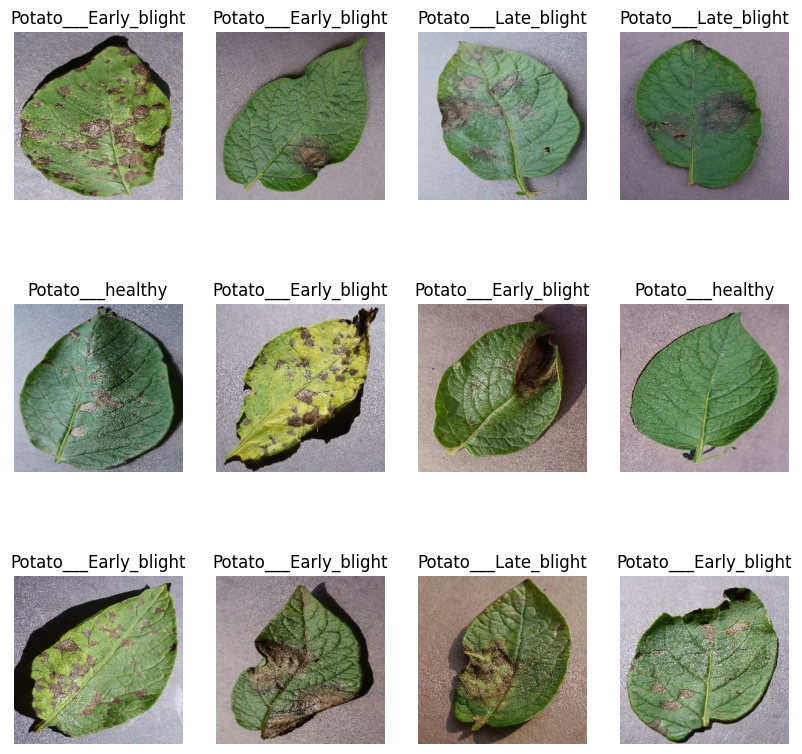

In [8]:
plt.figure(figsize=(10,10))
for image_batch, label_batch in dataset.take(1):
    for i in range(12):
        ax = plt.subplot(3,4, i+1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(classname[labels_batch[i]])
        plt.axis("off")

Dataset Splitting
We divide the dataset into three parts:

Training (80%) - Used to train the model.
Validation (10%) - Used to tune hyperparameters.
Testing (10%) - Used to evaluate final performance.

In [9]:
train_size = 0.8  # 80% of the dataset for training
len(dataset) * train_size


54.400000000000006

In [10]:
train_ds = dataset.take(54)  # Take the first 54 batches as training data
len(train_ds)

54

Splitting the Testing Set

In [11]:
test_ds = dataset.skip(54)  # Skip the training batches to get the remaining data
len(test_ds)  # Check how many batches are left

14

Splitting the Validation Set

In [12]:
val_size = 0.1
len(dataset) * val_size

6.800000000000001

In [13]:
val_ds = test_ds.take(6)
len(val_ds)

6

Finalizing the Test Set

In [14]:
test_ds = test_ds.skip(6)
len(test_ds)

8

In [15]:
train_split = 0.8
val_split = 0.1
test_split = 0.1

assert train_split + val_split + test_split == 1

This function partitions a dataset into training, validation, and testing subsets.

Shuffling ensures randomness (useful for training).
Take and skip operations help split data efficiently.

In [16]:
def get_dataset_paratitions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
    assert train_split + val_split + test_split == 1

    ds_size = len(ds)
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)
    train_size = int(train_split*ds_size) # Compute training set size
    val_size = int(val_split*ds_size) # Compute validation set size

    train_ds = ds.take(train_size)
    val_ds = ds.skip(train_size).take(val_size) # Take next N samples for validation
    test_ds = ds.skip(train_size).skip(val_size) # Remaining samples for testing

    return train_ds, val_ds, test_ds

Apply Partitioning to Dataset

In [17]:
train_ds, val_ds, test_ds = get_dataset_paratitions_tf(dataset)

Data optimization

In [18]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)

Data Resizing & Normalization
To ensure all images have the same dimensions and pixel values are normalized.

In [19]:
resize_and_rescale = tf.keras.Sequential([
    tf.keras.layers.Resizing(IMAGE_SIZE, IMAGE_SIZE),
    tf.keras.layers.Rescaling(1.0/255)
])

Data Augmentation
To improve model generalization, we apply:

Random Flipping (both horizontal and vertical)
Random Rotation (up to 20% of the image)

In [20]:
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal_and_vertical"),
    tf.keras.layers.RandomRotation(0.2)
])

Efficiently applies augmentations during training without modifying the original dataset.



In [21]:
train_ds = train_ds.map(
    lambda x, y: (data_augmentation(x, training=True), y)
).prefetch(buffer_size=tf.data.AUTOTUNE)


Model Architecture

In [22]:
# Import necessary libraries from TensorFlow
from tensorflow.keras import layers, models

input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes = 3

# Define the model
model = models.Sequential([
    resize_and_rescale,  # Rescale input values (normalization)

    # First Convolutional + MaxPooling layer
    layers.Conv2D(32, kernel_size=(3,3), activation='relu', input_shape=input_shape),
    layers.MaxPooling2D(2,2),

    # Second Convolutional + MaxPooling layer
    layers.Conv2D(64, kernel_size=(3,3), activation='relu'),
    layers.MaxPooling2D(2,2),

    # Third Convolutional + MaxPooling layer
    layers.Conv2D(64, kernel_size=(3,3), activation='relu'),
    layers.MaxPooling2D(2,2),

    # Fourth Convolutional + MaxPooling layer
    layers.Conv2D(64, kernel_size=(3,3), activation='relu'),
    layers.MaxPooling2D(2,2),

    # Fifth Convolutional + MaxPooling layer
    layers.Conv2D(64, kernel_size=(3,3), activation='relu'),
    layers.MaxPooling2D(2,2),

    layers.Flatten(),  # Flatten feature maps into a 1D vector
    layers.Dense(64, activation='relu'),  # Fully connected layer
    layers.Dense(n_classes, activation='softmax')  # Output layer with softmax for classification
])


Model summary

In [23]:
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ sequential (Sequential)              │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ ?                           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ ?                           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ ?                           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ ?                           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ ?                           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [24]:
# Compile the model
model.compile(
    optimizer='adam',  # Use Adam optimizer for training
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),  # Loss function for multi-class classification
    metrics=['accuracy']  # Track accuracy during training
)

In [25]:
# Train the model
history = model.fit(
    train_ds,  # Training dataset
    epochs=10,  # Train for 10 epochs
    batch_size=BATCH_SIZE,  # Number of samples per batch
    verbose=1,  # Display training progress
    validation_data=val_ds  # Validation dataset to check performance
)

Epoch 1/10
54/54 ━━━━━━━━━━━━━━━━━━━━ 426s 508ms/step - accuracy: 0.5375 - loss: 0.9026 - val_accuracy: 0.6719 - val_loss: 0.8264
Epoch 2/10
54/54 ━━━━━━━━━━━━━━━━━━━━ 37s 350ms/step - accuracy: 0.7885 - loss: 0.5507 - val_accuracy: 0.8750 - val_loss: 0.3112
Epoch 3/10
54/54 ━━━━━━━━━━━━━━━━━━━━ 20s 345ms/step - accuracy: 0.8835 - loss: 0.3010 - val_accuracy: 0.8073 - val_loss: 0.4387
Epoch 4/10
54/54 ━━━━━━━━━━━━━━━━━━━━ 19s 350ms/step - accuracy: 0.8762 - loss: 0.3226 - val_accuracy: 0.9167 - val_loss: 0.2233
Epoch 5/10
54/54 ━━━━━━━━━━━━━━━━━━━━ 20s 341ms/step - accuracy: 0.9289 - loss: 0.1968 - val_accuracy: 0.9427 - val_loss: 0.1574
Epoch 6/10
54/54 ━━━━━━━━━━━━━━━━━━━━ 19s 347ms/step - accuracy: 0.9351 - loss: 0.1605 - val_accuracy: 0.9635 - val_loss: 0.1433
Epoch 7/10
54/54 ━━━━━━━━━━━━━━━━━━━━ 19s 348ms/step - accuracy: 0.9323 - loss: 0.1665 - val_accuracy: 0.9427 - val_loss: 0.1317
Epoch 8/10
54/54 ━━━━━━━━━━━━━━━━━━━━ 20s 364ms/step - accuracy: 0.9294 - loss: 0.1723 - val_acc

Model Evaluation

In [26]:
scores = model.evaluate(test_ds)

8/8 ━━━━━━━━━━━━━━━━━━━━ 6s 22ms/step - accuracy: 0.8910 - loss: 0.2243


In [27]:
# Extract accuracy and loss values from training history
acc = history.history['accuracy']  # Training accuracy
val_acc = history.history['val_accuracy']  # Validation accuracy
loss = history.history['loss']  # Training loss
val_loss = history.history['val_loss']  # Validation loss

In [28]:
val_acc

[0.671875,
 0.875,
 0.8072916865348816,
 0.9166666865348816,
 0.9427083134651184,
 0.9635416865348816,
 0.9427083134651184,
 0.953125,
 0.9322916865348816,
 0.9375]

Visualize Loss & Accuarcy in Graph

Text(0.5, 1.0, 'Training & Validation Accuracy')

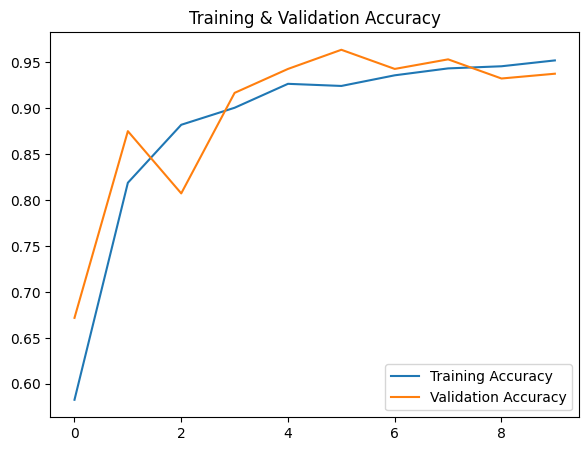

In [29]:
# Set figure size for the plots
plt.figure(figsize=(15, 5))

# Plot Training & Validation Accuracy
plt.subplot(1, 2, 1)  # Create subplot (1 row, 2 columns, first plot)
plt.plot(range(10), acc, label="Training Accuracy")  # Plot training accuracy
plt.plot(range(10), val_acc, label="Validation Accuracy")  # Plot validation accuracy
plt.legend(loc='lower right')  # Add legend at the lower right
plt.title('Training & Validation Accuracy')  # Set title

Text(0.5, 1.0, 'Training & Validation Loss')

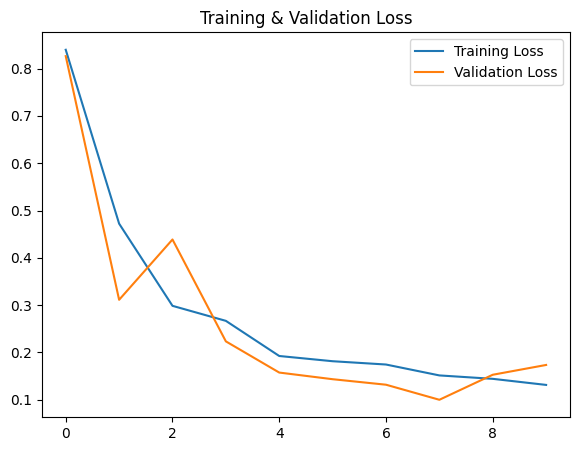

In [30]:
# Set figure size for the plots
plt.figure(figsize=(15, 5))

# Plot Training & Validation Loss
plt.subplot(1, 2, 2)  # Create subplot (1 row, 2 columns, second plot)
plt.plot(range(10), loss, label="Training Loss")  # Plot training loss
plt.plot(range(10), val_loss, label="Validation Loss")  # Plot validation loss
plt.legend(loc='upper right')  # Add legend at the upper right
plt.title('Training & Validation Loss')  # Set title

Model Prediction

First image to predict
Actual label: Potato___Early_blight
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 480ms/step
Predicted label: Potato___Early_blight


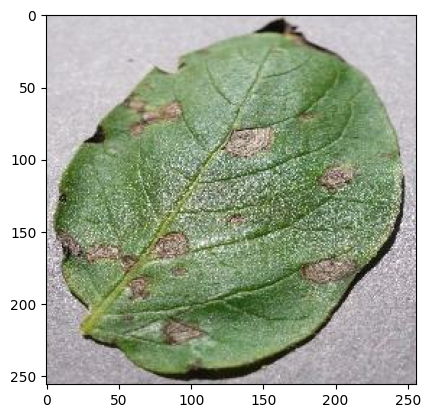

In [31]:
import numpy as np  # Import NumPy for numerical operations

# Take one batch of images and labels from test dataset
for image_batch, labels_batch in test_ds.take(1):
    first_img = image_batch[0].numpy().astype('uint8')  # Convert first image to uint8 for visualization
    first_label = labels_batch[0].numpy()  # Get the actual label

    print("First image to predict")
    plt.imshow(first_img)  # Display the image
    print('Actual label:', classname[first_label])  # Print actual label

    # Make predictions on the batch
    batch_prediction = model.predict(image_batch)
    print('Predicted label:', classname[np.argmax(batch_prediction[0])])  # Get predicted class


In [32]:
# Function to make predictions on a single image
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(img.numpy())  # Convert image to array
    img_array = tf.expand_dims(img_array, 0)  # Expand dimensions to match model input shape

    prediction = model.predict(img_array)  # Make a prediction

    predicted_class = classname[np.argmax(prediction[0])]  # Get predicted class
    confidence = round(100 * (np.max(prediction[0])), 2)  # Get confidence percentage
    return predicted_class, confidence

In [33]:
# Create a figure for displaying predictions
plt.figure(figsize=(15, 15))

# Loop through test dataset and display 9 images with predictions
for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)  # Create a 3x3 grid for displaying images
        plt.imshow(images[i].numpy().astype("uint8"))  # Show image

        predicted_class, confidence = predict(model, images[i])  # Get prediction
        actual_class = classname[labels[i]]  # Get actual class

        # Set title with actual, predicted class, and confidence
        plt.title(f"Actual: {actual_class}, \n Predicted: {predicted_class}. \n Confidence: {confidence}%")

        plt.axis("off")  # Hide axes for better visualization

Output hidden; open in https://colab.research.google.com to view.